<h2> Analysis of Bone Mineral Densities in MrOS B1 Data (EDA1.ipynb) </h2> 

The purpose of this workbook is take begin exploring the vast amount of data that we have.  Through various methods of exploration, we hope to find general trends, patterns, and correlations in the data that will help lead to us a reliable predictive model. 

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Exploration of NA Values](#eda_na)
#### 4. [Merging of Data](#eda_merge)
#### 5. [Descriptive Statistics](#eda_describe)
#### 6. [Outlier Review](#eda_outlier)
#### 7. [Principal Component Review](#eda_PCA)
#### 8. [Using Feature Selection](#eda_FS)

### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [66]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [67]:
##import libraries required for analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

In [68]:
sns.__version__

'0.12.2'

### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

As we've described, the dataset is very wide and in order to properly analyze, we need to reduce the number of features we're looking at. 
1. From the b1aug16_raw table, we're limiting the columns to values containing bone mineral densities using regular expressions.
2. From the FAFEB23.SAS7BDAT file, we're limiting the columns to "ID","FANOTMOF".

In [69]:
##Connect to Postgre
import psycopg2
import sqlalchemy
import getpass
import pandas as pd 

user = "jwj8c8"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [70]:
def binary2StringLiteral(df):
    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.decode('utf-8')

In [71]:
query = "SELECT * FROM public.b1aug16_raw"
b1aug16_df = pd.read_sql_query(query, con=connection)

In [72]:
fafeb23_df = pd.read_sas("/dsa/groups/casestudy2023su/team03/FAFEB23.SAS7BDAT")
fafeb23_df = fafeb23_df[["ID","FANOTMOF"]]
binary2StringLiteral(fafeb23_df)

In [73]:
##BMD values end in D
##Operator code for Hip scan, Spine Scan, and Whole Body Scan end in COD these values will need to be removed
##We will use a Negative lookback assertion 
##This method retains the various IDs in the table
baselineBMD = b1aug16_df.filter(regex="(?<!(CO))D$",axis=1)
baselineBMD.head()

,B1TRD,B1ITD,B1FND,B1WDD,B1THD,B1HPID,ID,B1L1D,B1L2D,B1L3D,...,B1LAD,B1RAD,B1LRD,B1RRD,B1TSD,B1LSD,B1PED,B1LLD,B1RLD,B1WBID
0,0.816111,1.22431,0.867423,0.784696,1.046450,A04250007,BI0001,1.135320,1.17017,1.244590,...,0.931609,0.943192,0.743156,0.659102,0.928960,1.35857,1.15584,1.27166,1.29073,A04250008
1,0.879885,1.11591,0.740235,0.519868,0.977156,A05020006,BI0002,1.233880,1.26274,1.194060,...,0.886045,0.930573,0.775296,0.740078,1.188770,1.33318,1.32048,1.27454,1.31312,A05020007
2,0.690143,1.12294,0.691843,0.505692,0.938607,A05030006,BI0003,0.745454,0.88662,0.964876,...,0.841374,0.878078,1.143010,0.698110,0.950109,0.89908,1.09222,1.23404,1.28587,A05030007
3,0.854573,1.14140,0.878307,0.648614,1.017220,A0503000A,BI0004,1.169730,1.31559,1.261980,...,0.894172,0.905256,0.808074,0.740336,1.406840,1.34156,1.36052,1.44115,1.40465,A0503000B
4,0.894594,1.25773,0.919494,0.585505,1.104740,A05040005,BI0005,1.036480,1.22224,1.176640,...,0.966746,0.969560,0.803625,0.747750,1.053460,1.16267,1.21803,1.68334,1.45254,A05040006


### <a name="eda_na"></a>Exploration of NA Values
Here we're doing initial exploration of the NAs present within each feature and dropping them which results in a loss of 134 rows. 

In [74]:
baselineBMD.isna().sum()

B1TRD      1
B1ITD      1
B1FND      1
B1WDD      1
B1THD      1
B1HPID     0
ID         0
B1L1D     35
B1L2D     24
B1L3D     35
B1L4D     66
B1TLD     10
B1SPID     7
B1TBD     39
B1SBD     39
B1HDD     39
B1LAD     39
B1RAD     39
B1LRD     39
B1RRD     39
B1TSD     39
B1LSD     39
B1PED     39
B1LLD     39
B1RLD     39
B1WBID    38
dtype: int64

In [75]:
baselineBMD.isna().sum()/baselineBMD.shape[0]

B1TRD     0.000167
B1ITD     0.000167
B1FND     0.000167
B1WDD     0.000167
B1THD     0.000167
B1HPID    0.000000
ID        0.000000
B1L1D     0.005839
B1L2D     0.004004
B1L3D     0.005839
B1L4D     0.011011
B1TLD     0.001668
B1SPID    0.001168
B1TBD     0.006507
B1SBD     0.006507
B1HDD     0.006507
B1LAD     0.006507
B1RAD     0.006507
B1LRD     0.006507
B1RRD     0.006507
B1TSD     0.006507
B1LSD     0.006507
B1PED     0.006507
B1LLD     0.006507
B1RLD     0.006507
B1WBID    0.006340
dtype: float64

In [76]:
baselineBMD.shape

(5994, 26)

In [77]:
baselineBMD = baselineBMD.dropna()

In [78]:
baselineBMD.dropna().shape

(5860, 26)

### <a name="eda_merge"></a> Merging of Data
The datasets that we have can all be merged with the "ID" field that is representative of a unique MrOS patient.

In [79]:
mergedData = baselineBMD.merge(fafeb23_df,on="ID",how="inner")

In [80]:
##Drop NAs in the target variable
mergedData = mergedData.dropna()

In [81]:
##Drop IDs and target variable
baselineBMD = mergedData.filter(regex="(?<!I)D")
y = mergedData.FANOTMOF

In [82]:
##Clean up the target variable names
y = y.map({1:"Fracture",0:"No Fracture"})

<a name="eda_describe"></a><h3> Descriptive Statistics </h3>
Below are a set of descriptive statistics meant to familiarize the audience

In [83]:
baselineBMD.describe().T

,count,mean,std,min,25%,50%,75%,max
B1TRD,5783.0,0.766082,0.126634,0.167047,0.678354,0.759600,0.847868,1.69903
B1ITD,5783.0,1.113665,0.165548,0.389357,1.000965,1.106720,1.222735,1.85264
B1FND,5783.0,0.785594,0.127617,0.272729,0.697730,0.774826,0.861795,1.49072
B1WDD,5783.0,0.551745,0.142644,0.065489,0.452576,0.535078,0.634537,1.54177
B1THD,5783.0,0.959107,0.139649,0.306135,0.864781,0.952282,1.050770,1.72724
B1L1D,5783.0,0.980633,0.176218,0.298691,0.860885,0.969173,1.087485,1.97685
B1L2D,5783.0,1.061342,0.192640,0.415088,0.929544,1.048220,1.177015,2.25681
B1L3D,5783.0,1.099793,0.206546,0.382238,0.957046,1.082680,1.220385,2.24568
B1L4D,5783.0,1.134759,0.216883,0.485280,0.984924,1.110510,1.262505,2.38017
B1TLD,5783.0,1.073384,0.186012,0.468967,0.943904,1.059790,1.186015,2.09886


<a name="eda_outlier"></a><h3> Outlier Review </h3>
The outlier analysis does show a number of outliers both above and below the outlier range created by the boxplot rule. However, using the boxplots, none of the readings appear to be clinically incorrect which would warrant removing them. Furthermore, outliers in a clinical setting may reveal important information.Thus, these outliers will remain in the data set. For now.

In [84]:
Outlier_df = pd.DataFrame(columns=baselineBMD.columns)
for column in baselineBMD.columns:
    q1 = baselineBMD[column].quantile(0.25)
    q3 = baselineBMD[column].quantile(0.75)
    iqr = q3 - q1
    Outlier_df.at["Count Above",column] = baselineBMD[baselineBMD[column] > q3 + 1.5*iqr][column].count()
    Outlier_df.at["Count Below",column] = baselineBMD[baselineBMD[column] < q1 - 1.5*iqr][column].count()


In [85]:
Outlier_df.T

,Count Above,Count Below
B1TRD,39,9
B1ITD,34,15
B1FND,91,6
B1WDD,90,5
B1THD,40,12
B1L1D,68,10
B1L2D,90,10
B1L3D,95,7
B1L4D,101,3
B1TLD,82,6


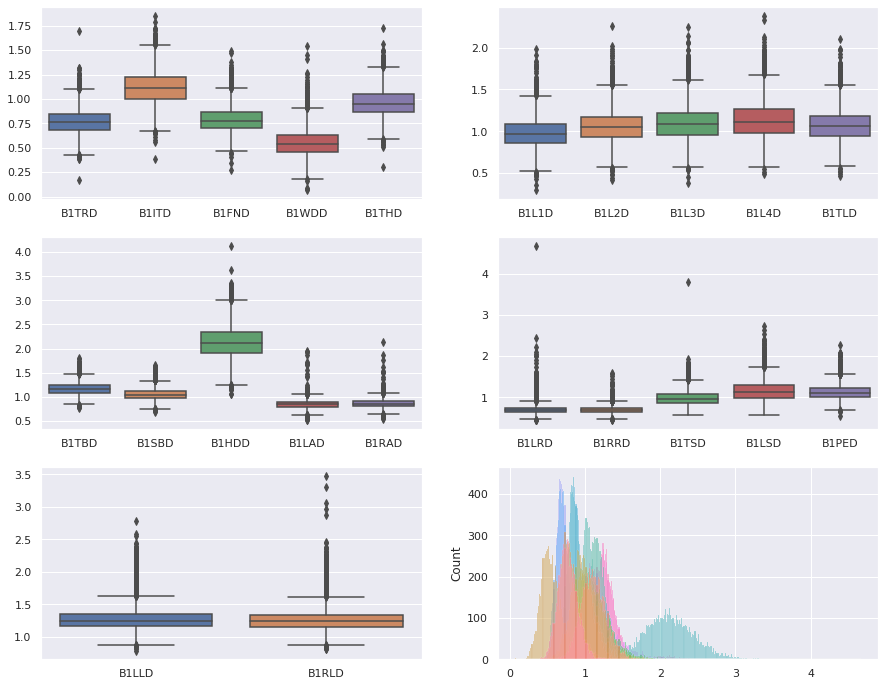

In [86]:
sns.set(rc={'figure.figsize':(15,12)})
fig, axs = plt.subplots(ncols=2,nrows=3)
sns.boxplot(data=baselineBMD.iloc[:,0:5],ax=axs[0,0])
sns.boxplot(data=baselineBMD.iloc[:,5:10],ax=axs[0,1])
sns.boxplot(data=baselineBMD.iloc[:,10:15],ax=axs[1,0])
sns.boxplot(data=baselineBMD.iloc[:,15:20],ax=axs[1,1])
sns.boxplot(data=baselineBMD.iloc[:,20:],ax=axs[2,0])
sns.histplot(data=baselineBMD,ax=axs[2,1],legend=False)

Interesting observation from the boxplot and histogram, The bone mineral density of the head is much greater than the others.

In [111]:
sns.reset_defaults()

### <a name="eda_PCA"></a> Principal Component Review
From initial review, we were able to confirm what we've read from the literature - the majority of the variance can be explained with the first principle component.  

Minimal clustering was found when exploring the top three principle components.

In [87]:
pca = PCA(n_components=3)
baselineBMD_scaled = StandardScaler().fit_transform(baselineBMD)
pca.fit(baselineBMD_scaled)
pcaBMD = pca.transform(baselineBMD_scaled)

In [88]:
pca.components_

array([[ 0.22495794,  0.21906261,  0.21663806,  0.20244607,  0.23354753,
         0.22393645,  0.22715683,  0.22623192,  0.21555175,  0.23795142,
         0.24942592,  0.24993192,  0.15334486,  0.19002437,  0.20809576,
         0.14449488,  0.19940369,  0.21345835,  0.22628702,  0.2317078 ,
         0.18149054,  0.17688216],
       [-0.15864047, -0.22352048, -0.19848733, -0.20134148, -0.21411802,
         0.26533213,  0.31589308,  0.33228114,  0.32323204,  0.33265462,
        -0.11269388, -0.14630706,  0.01465252, -0.18623586, -0.17835374,
        -0.02156962, -0.03396296,  0.10152356,  0.32207271, -0.05895183,
        -0.18574235, -0.22114458],
       [-0.27363144, -0.29741371, -0.34448405, -0.34389986, -0.3092962 ,
        -0.04634119, -0.03389949, -0.02260038, -0.02160248, -0.0319052 ,
         0.28741852,  0.26735571,  0.17871901,  0.14724011,  0.09779857,
         0.13693422,  0.13405723,  0.05678667, -0.03770047, -0.04090381,
         0.34804786,  0.34252934]])

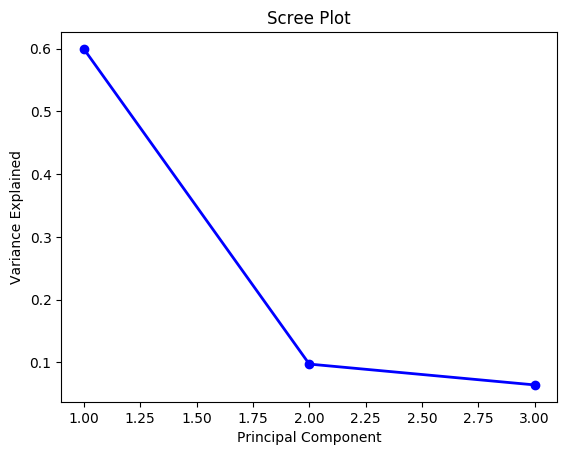

In [112]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Most of the variance is in the first principal component with extreme diminishing returns.This corresponds to the known literature.

In [90]:
pcaBMD_df = pd.DataFrame(pcaBMD,columns=["Component 1","Component 2","Component 3"])

In [91]:
pcaBMD_df = pd.concat([pcaBMD_df,y],axis=1)

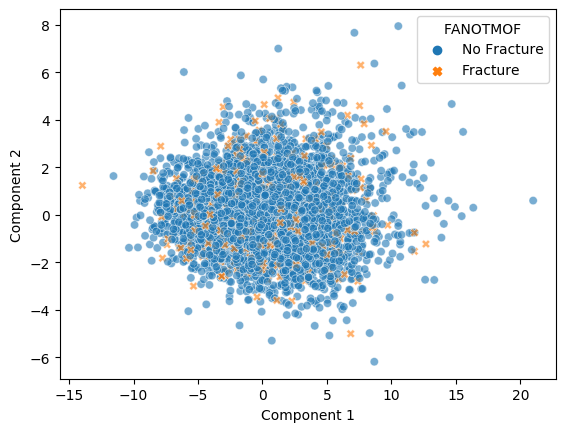

In [113]:
sns.scatterplot(data=pcaBMD_df, x="Component 1",y="Component 2",hue="FANOTMOF",style="FANOTMOF",alpha=0.6)
plt.show()

Let's get a better view by plotting Fractures on top of Non-fractures

/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/conda/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


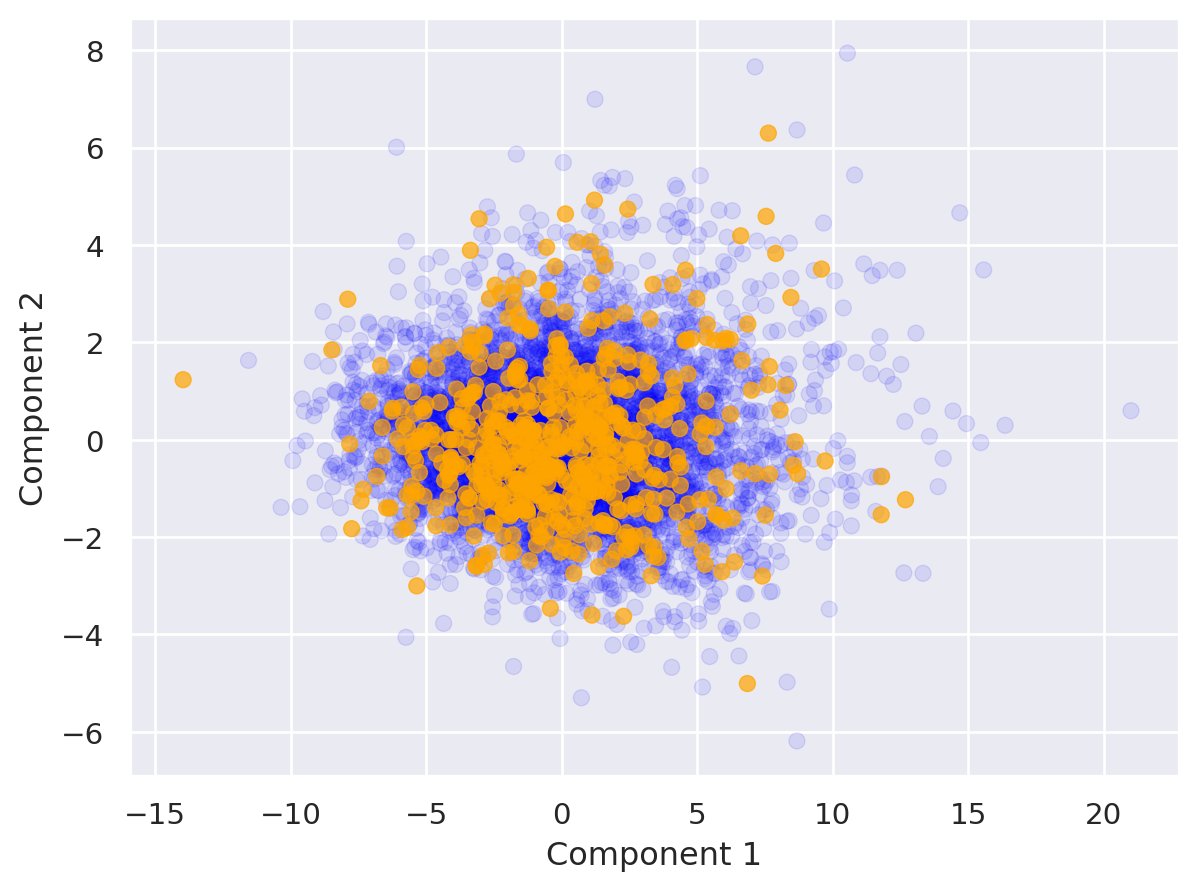

In [93]:
so.Plot(pcaBMD_df,x="Component 1",y="Component 2")\
.add(so.Dot(color="blue",alpha=0.1),data=pcaBMD_df[pcaBMD_df.FANOTMOF == "No Fracture"])\
.add(so.Dot(color="orange",alpha=0.7),data=pcaBMD_df[pcaBMD_df.FANOTMOF == "Fracture"])

The plot of the first two principal components doesn't show much evidence of clustering. However, we can see in the first principal component that scores under zero have a larger portion of the fractures.

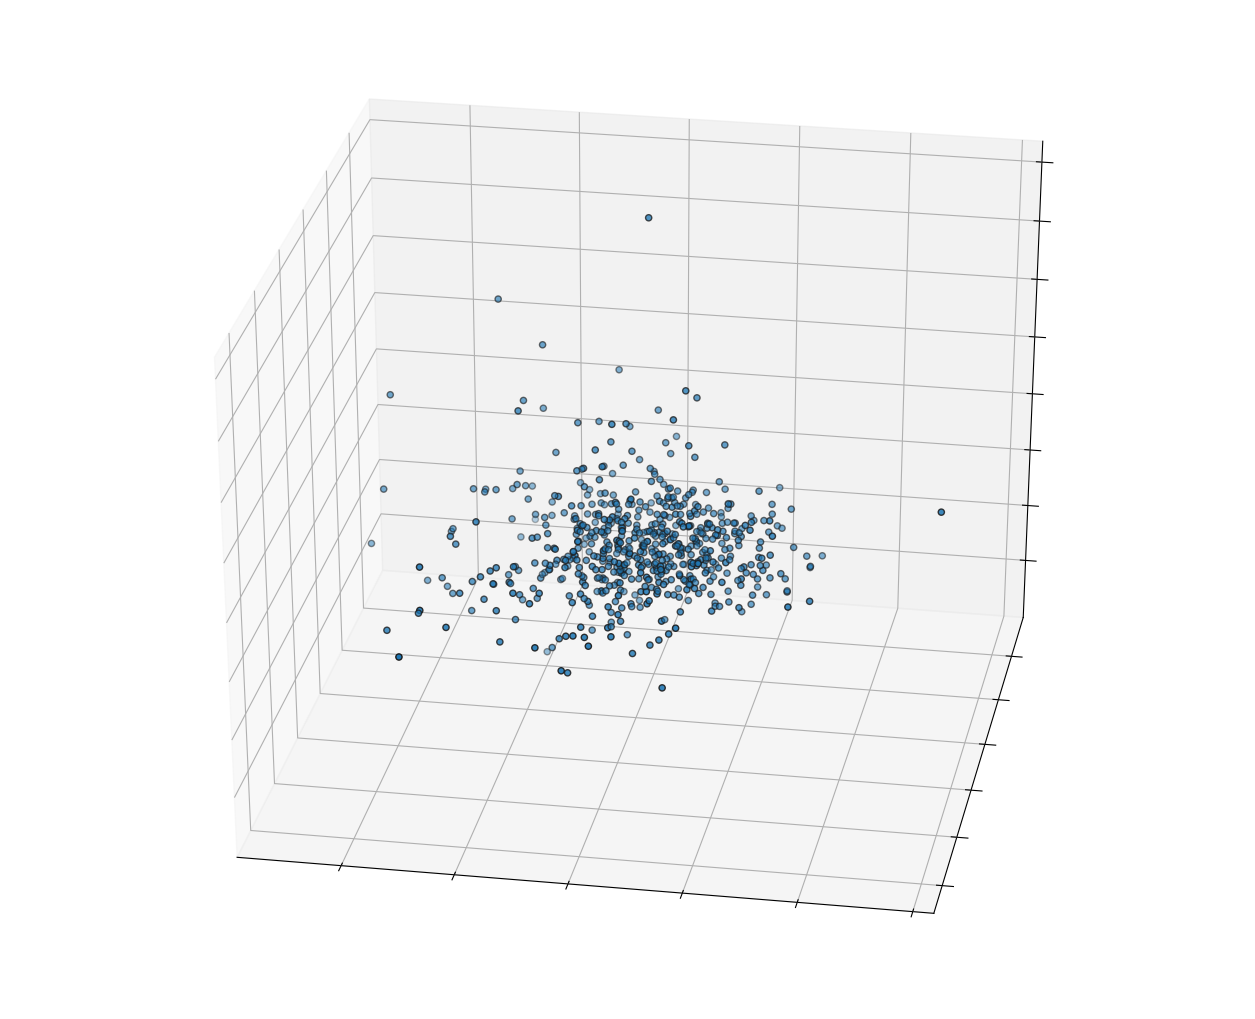

In [114]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 1"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 2"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="Fracture"]["Component 3"], edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

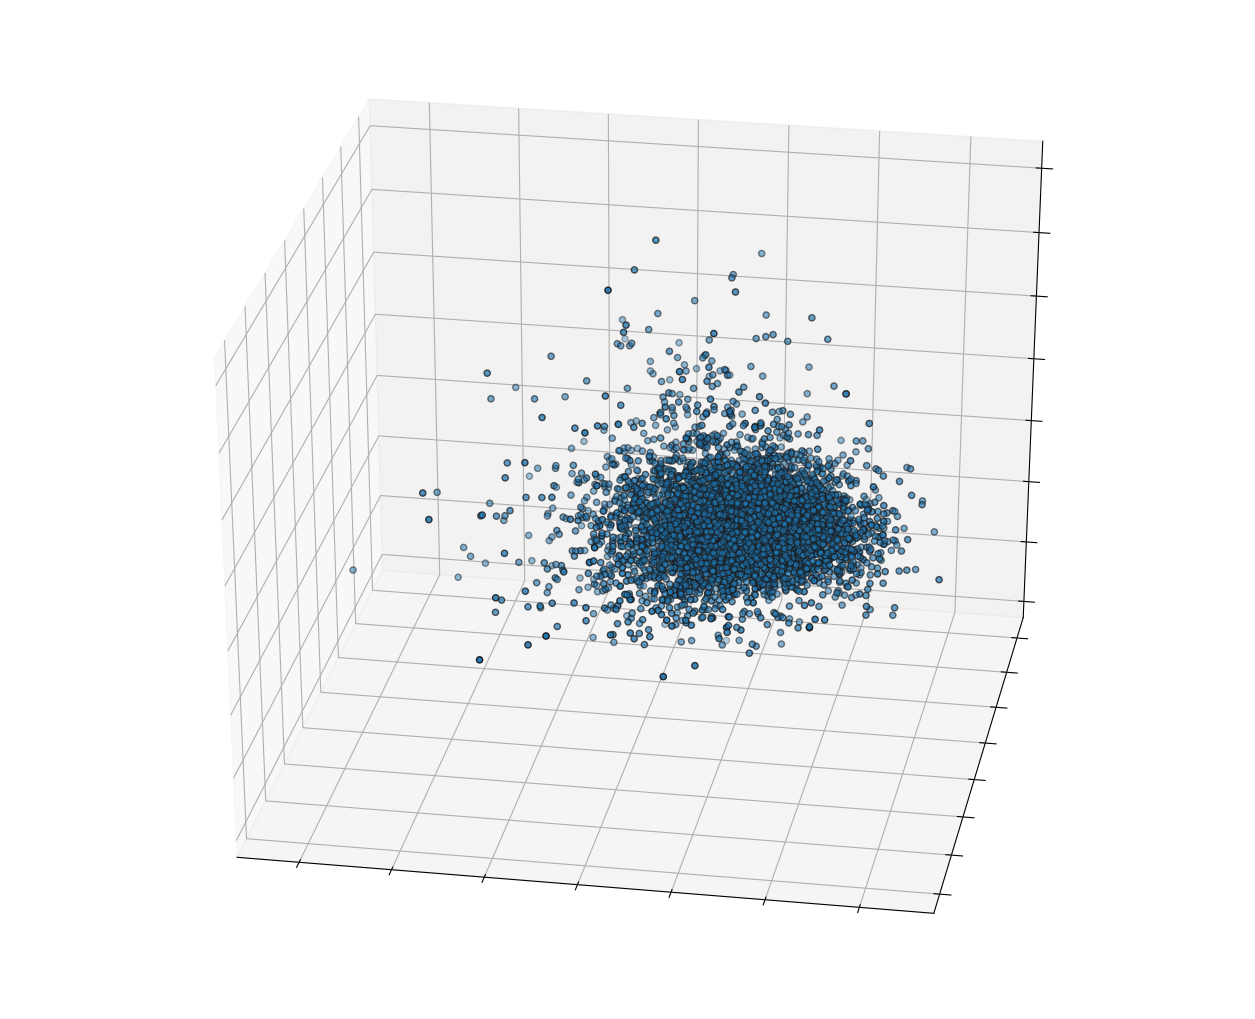

In [115]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 1"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 2"], pcaBMD_df[pcaBMD_df["FANOTMOF"]=="No Fracture"]["Component 3"], edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

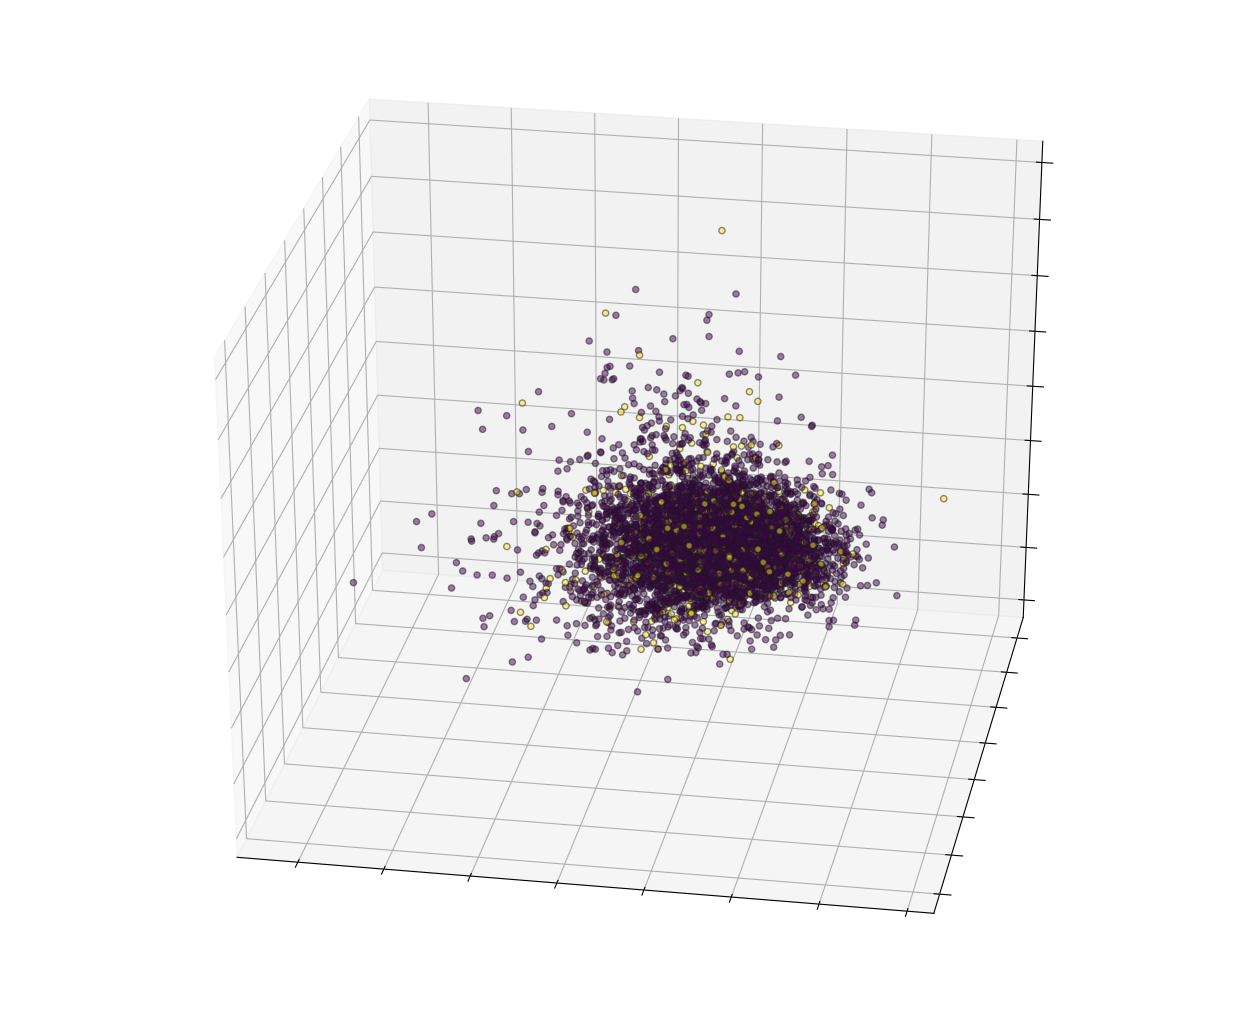

In [116]:
fig = plt.figure(1, figsize=(13,10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=30, azim=100)
ax.set_position([0, 0, 0.95, 1])


plt.cla()

ax.scatter(pcaBMD_df["Component 1"], pcaBMD_df["Component 2"], pcaBMD_df["Component 3"], c=pcaBMD_df["FANOTMOF"].map({"Fracture":1,"No Fracture":0}), edgecolor="k", alpha = 0.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

plt.show()

There is not a clear distinction even amongst three principal components

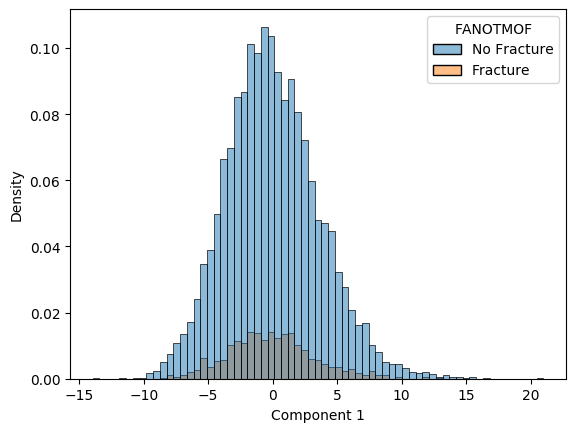

In [117]:
sns.histplot(data=pcaBMD_df, x="Component 1", hue="FANOTMOF",stat="density")

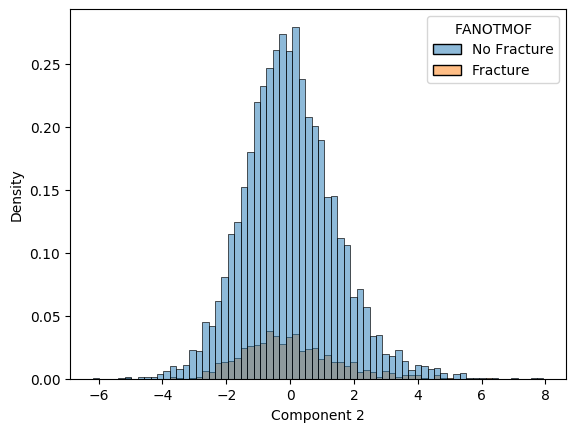

In [118]:
sns.histplot(data=pcaBMD_df, x="Component 2", hue="FANOTMOF",stat="density")

In [99]:
pcaBMD_df.groupby("FANOTMOF").aggregate(["mean","max","min"]).T

FANOTMOF           Fracture  No Fracture
Component 1 mean  -0.077476     0.002551
            max   12.676380    20.994276
            min  -13.965262   -11.554358
Component 2 mean  -0.021920     0.001467
            max    6.295388     7.937624
            min   -5.009036    -6.187492
Component 3 mean   0.031870    -0.000618
            max    9.632692     7.853578
            min   -5.034993    -5.565472

Descriptive statistics show that there is a slight difference between populations using the Principal Component Method

### <a name="eda_FS"></a>Using Feature Selection

The analysis below shows that there is a clear distinction between the "fracture" and "no fracture" population.  This also confirms what we had read during our literature review. 

In [100]:
##Top five based on f classifier

In [101]:
TopFeatures = SelectKBest(f_classif, k=5).fit(baselineBMD,y).get_support(indices=True)

In [102]:
TopBaseline = baselineBMD.iloc[:,TopFeatures]

In [103]:
TopMerged = pd.concat([TopBaseline,y],axis=1)

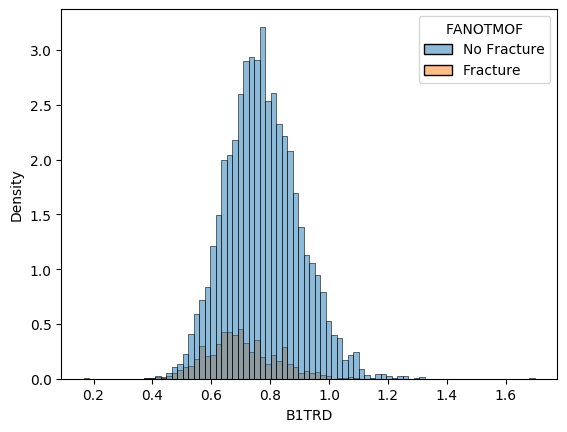

In [119]:
sns.histplot( x=TopBaseline.iloc[:,0], hue=y,stat="density")

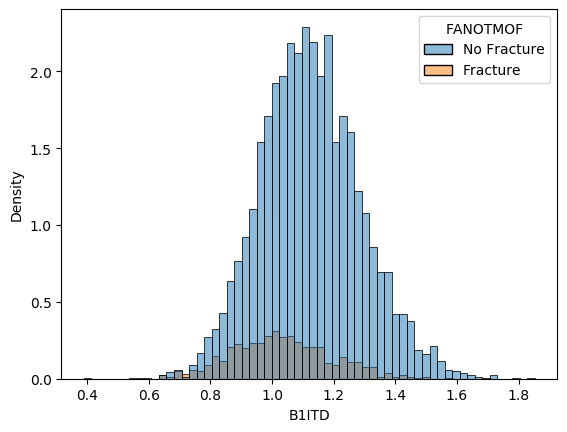

In [120]:
sns.histplot( x=TopBaseline.iloc[:,1], hue=y,stat="density")

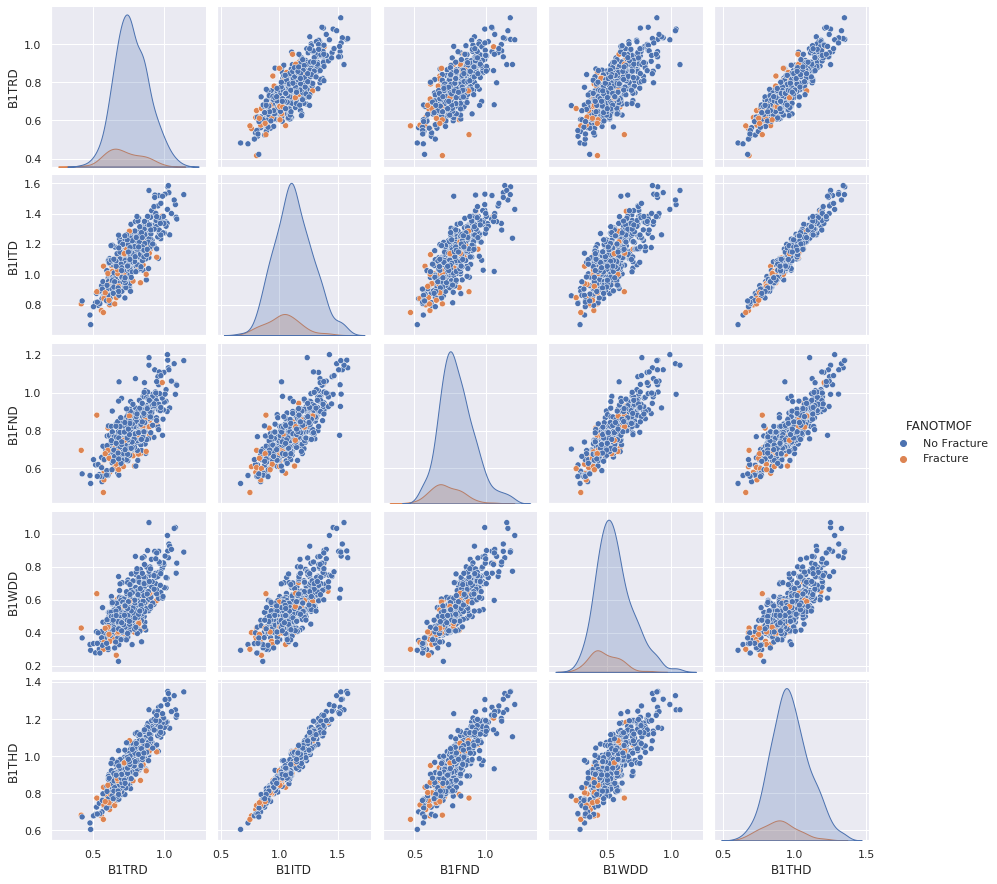

In [106]:
sns.pairplot(data=TopMerged.sample(500),hue="FANOTMOF")

In [107]:
TopMerged.groupby("FANOTMOF").aggregate(["mean","max","min"]).T

FANOTMOF    Fracture  No Fracture
B1TRD mean  0.701790     0.774027
      max   1.093780     1.699030
      min   0.167047     0.385267
B1ITD mean  1.029270     1.124093
      max   1.580770     1.852640
      min   0.389357     0.554777
B1FND mean  0.719590     0.793750
      max   1.271720     1.490720
      min   0.272729     0.403934
B1WDD mean  0.478990     0.560735
      max   1.092780     1.541770
      min   0.065489     0.084152
B1THD mean  0.883659     0.968430
      max   1.302000     1.727240
      min   0.306135     0.509475

From the above analysis, we can see a clear distinction between the two populations as BMD relates to incidence of fracture.